In [1]:
import sys
sys.path.append("/home/paj7rng/mobo_experiments/")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import distributions as dist 

from optimizers.banner_mimo import BaNNER_WS

from plotting.banner_plots import plot_meta_mean_var, plot_metadata

In [3]:
import math
from typing import Optional

import parameterspace as ps
from benchmarks_multitask.benchmarks.base import Base, SeedType


class ForresterFunctionPos:
    def __call__(self, x: float, a: float, b: float, c: float) -> float:
        if x > 0:
            y_high = math.pow(6 * x - 2, 2) * math.sin(12 * x - 4)
            y = a * y_high + b * (x - 0.5) - c
            return y
        else:
            return 0

class ForresterFunctionNeg:
    def __call__(self, x: float, a: float, b: float, c: float) -> float:
        if x <= 0:
            x = - x
            y_high = math.pow(6 * x - 2, 2) * math.sin(12 * x - 4)
            y = a * y_high + b * (x - 0.5) - c
            return y
        else:
            return 0


class ForresterPos(Base):
    def __init__(
        self, n_data_per_task=[4] * 128, seed: Optional[SeedType] = None, **kwargs
    ):
        descriptors = ps.ParameterSpace()
        descriptors.add(ps.ContinuousParameter(name="a", bounds=[0.2, 3]))
        descriptors.add(ps.ContinuousParameter(name="b", bounds=[-5, 15]))
        descriptors.add(ps.ContinuousParameter(name="c", bounds=[-5, 5]))

        settings = ps.ParameterSpace()
        context = ps.ParameterSpace()

        search_space = ps.ParameterSpace()
        search_space.add(ps.ContinuousParameter(name="x", bounds=[-1, 1]))

        target_task, meta_tasks = super().create_tasks(
            descriptors, settings, context, len(n_data_per_task), seed
        )
        super().__init__(
            descriptors,
            settings,
            context,
            search_space,
            target_task,
            meta_tasks,
            n_data_per_task,
            **kwargs
        )

    @property
    def function(self):
        return ForresterFunctionPos()


class ForresterNeg(ForresterPos):
    def __init__(
        self, n_data_per_task=[4] * 128, seed=None, **kwargs
    ):
        super().__init__(n_data_per_task, seed, **kwargs)

    @property
    def function(self):
        return ForresterFunctionNeg()

In [4]:
num_obs_per_task = 32
num_tasks_per_obj = 256
forrester_p = ForresterPos(n_data_per_task=[num_obs_per_task] * num_tasks_per_obj, seed=43)
forrester_n = ForresterNeg(n_data_per_task=[num_obs_per_task] * num_tasks_per_obj, seed=44)
meta_data_p = forrester_p.get_meta_data(distribution='sobol')
meta_data_n = forrester_n.get_meta_data(distribution='sobol')

## Meta-data

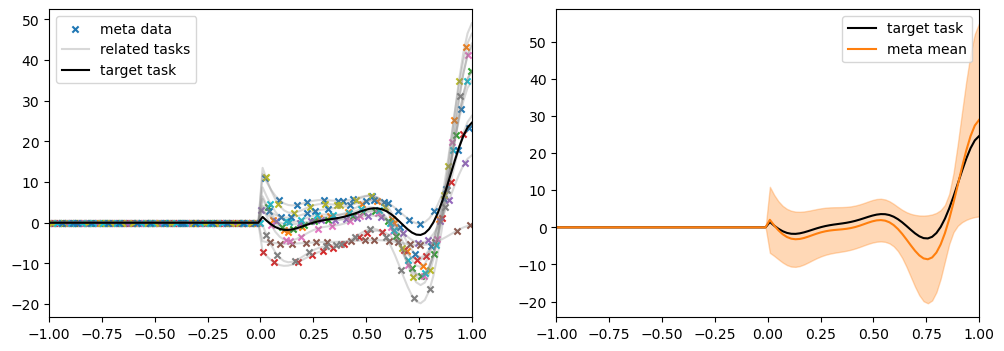

In [5]:
fig = plt.figure(figsize=(12, 4))

ax_meta = plt.subplot2grid((1, 2), (0, 0))
plot_metadata(forrester_p, meta_data_p, ax_meta)

ax_mean_var = plt.subplot2grid((1, 2), (0, 1))
plot_meta_mean_var(forrester_p, meta_data_p, ax_mean_var)

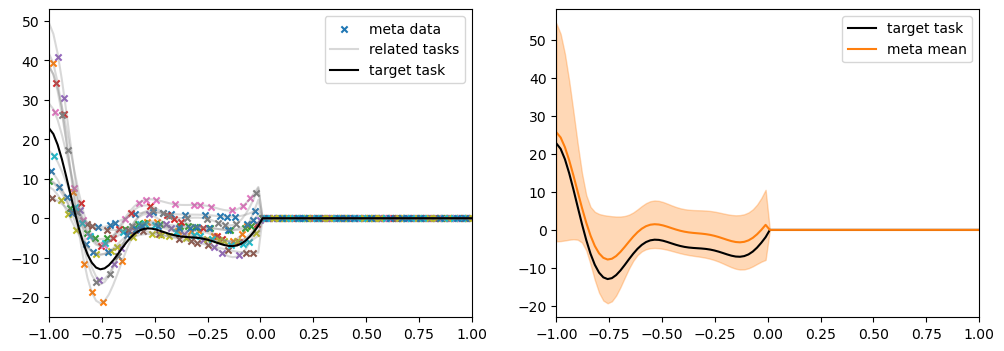

In [6]:
fig = plt.figure(figsize=(12, 4))

ax_meta = plt.subplot2grid((1, 2), (0, 0))
plot_metadata(forrester_n, meta_data_n, ax_meta)

ax_mean_var = plt.subplot2grid((1, 2), (0, 1))
plot_meta_mean_var(forrester_n, meta_data_n, ax_mean_var)

## Meta-learning

In [7]:
meta_data = dict()
k = 1
for obj, data in enumerate([meta_data_p, meta_data_n], start=1):
    for _, v in data.items():
        meta_data[(obj, k)] = v
        k += 1

In [8]:
device = "cuda"
num_features = 2
meta_model_config = {
    "num_layers": 6,
    "num_features": num_features,
    "num_hidden_units": 256,
    "device": device
}
train_config = {
    "num_epochs": 100,
    "batch_size": 256,
}

model = BaNNER_WS(forrester_p.search_space, **meta_model_config)
model.meta_fit(meta_data=meta_data, **train_config)

  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
x_config = np.linspace(-1, 1, 100).reshape(-1, 1)
x_numerical = []
for x in x_config:
    x_numerical.append(forrester_p.search_space.to_numerical({'x': x}))
x_numerical = np.array(x_numerical)

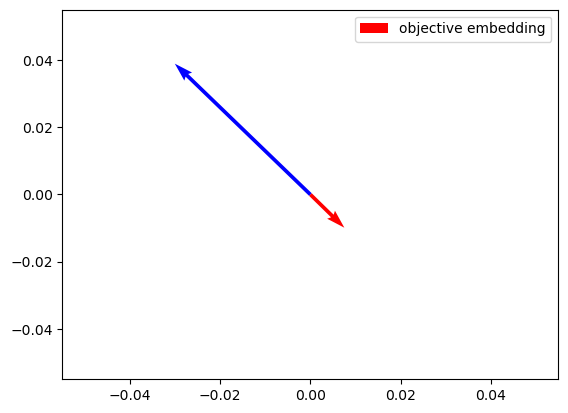

In [10]:
obj_coord = model.meta_blr.meta_model.obj_embedding.weight[1:,:].detach().cpu()
origin = np.array([[0, 0],[0, 0]])

plt.quiver(*origin, obj_coord[:,0], obj_coord[:,1], color=['r','b'], scale=3, label="objective embedding")
plt.legend()
plt.show()

### Objective 1

In [11]:
obj_embedding = torch.tensor([1], device=device)
mean, var = model.predict(x_numerical, obj_embedding=obj_embedding)

task_embeddings = model.meta_blr.meta_model.task_embedding.weight[1:num_tasks_per_obj+1, :].detach().cpu()

X = torch.tensor(x_numerical, device=device)
task_embedding = torch.tensor(0, device=device)
with torch.no_grad():
    features, _ = model.meta_blr.meta_model(X, obj_embedding, task_embedding)
features = features.detach().cpu() 

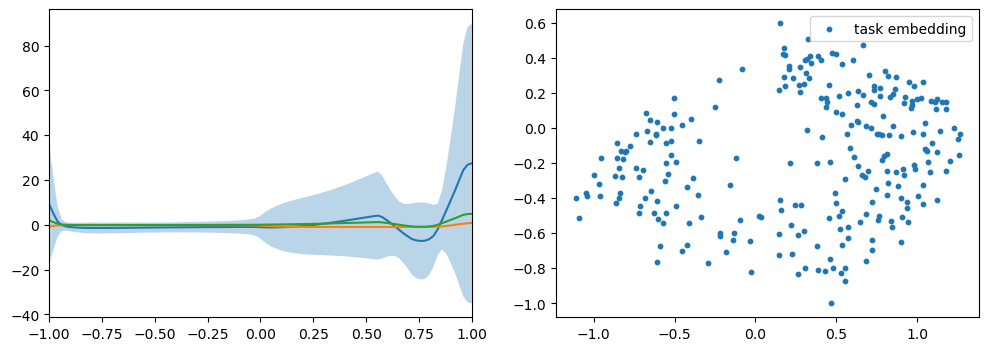

In [12]:
fig = plt.figure(figsize=(12, 4))
ax_meta = plt.subplot2grid((1, 2), (0, 0))
ax_meta.plot(x_config, mean)
ax_meta.fill_between(
    x_config.squeeze(),
    (mean + 2*np.sqrt(var)).squeeze(),
    (mean - 2*np.sqrt(var)).squeeze(),
    alpha=.3
)
for i in range(num_features):
    ax_meta.plot(x_config, features[:, i])
ax_meta.set_xlim(*forrester_p.search_space['x']['parameter'].bounds)

ax_embeddding = plt.subplot2grid((1, 2), (0, 1))
ax_embeddding.scatter(task_embeddings[:, 0], task_embeddings[:, 1], label='task embedding', s=10)
ax_embeddding.legend();

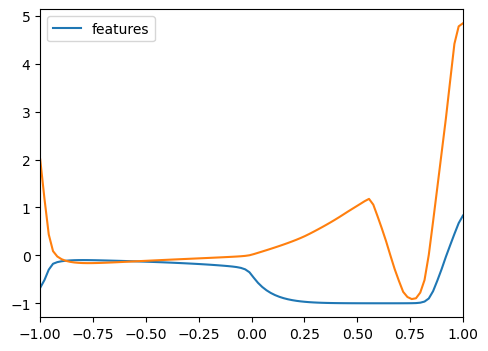

In [13]:
fig = plt.figure(figsize=(12, 4))
ax_meta = plt.subplot2grid((1, 2), (0, 0))
for i in range(num_features):
    ax_meta.plot(x_config, features[:, i], label='features' if i==0 else None)
ax_meta.legend()
ax_meta.set_xlim(*forrester_p.search_space['x']['parameter'].bounds);

### Objective 2

In [14]:
obj_embedding = torch.tensor([2], device=device)
mean, var = model.predict(x_numerical, obj_embedding=obj_embedding)

task_embeddings = model.meta_blr.meta_model.task_embedding.weight[num_tasks_per_obj+1:, :].detach().cpu()
    
X = torch.tensor(x_numerical, device=device)

task_embedding = torch.tensor(0, device=device)

with torch.no_grad():
    features, _ = model.meta_blr.meta_model(X, obj_embedding, task_embedding)
features = features.detach().cpu() 

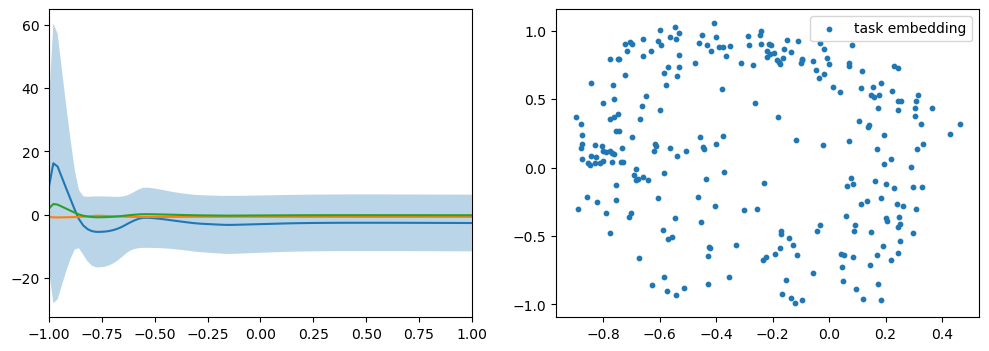

In [15]:
fig = plt.figure(figsize=(12, 4))
ax_meta = plt.subplot2grid((1, 2), (0, 0))
ax_meta.plot(x_config, mean)
ax_meta.fill_between(
    x_config.squeeze(),
    (mean + 2*np.sqrt(var)).squeeze(),
    (mean - 2*np.sqrt(var)).squeeze(),
    alpha=.3
)
for i in range(num_features):
    ax_meta.plot(x_config, features[:, i])
ax_meta.set_xlim(*forrester_p.search_space['x']['parameter'].bounds)

ax_embeddding = plt.subplot2grid((1, 2), (0, 1))
ax_embeddding.scatter(task_embeddings[:, 0], task_embeddings[:, 1], label='task embedding', s=10)
ax_embeddding.legend();

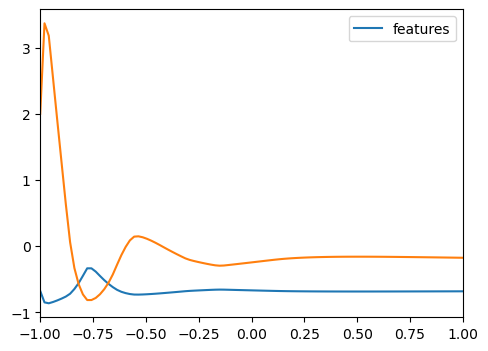

In [16]:
fig = plt.figure(figsize=(12, 4))
ax_meta = plt.subplot2grid((1, 2), (0, 0))
for i in range(num_features):
    ax_meta.plot(x_config, features[:, i], label='features' if i==0 else None)
ax_meta.legend()
ax_meta.set_xlim(*forrester_p.search_space['x']['parameter'].bounds);

## Train embedding visualization objective 1

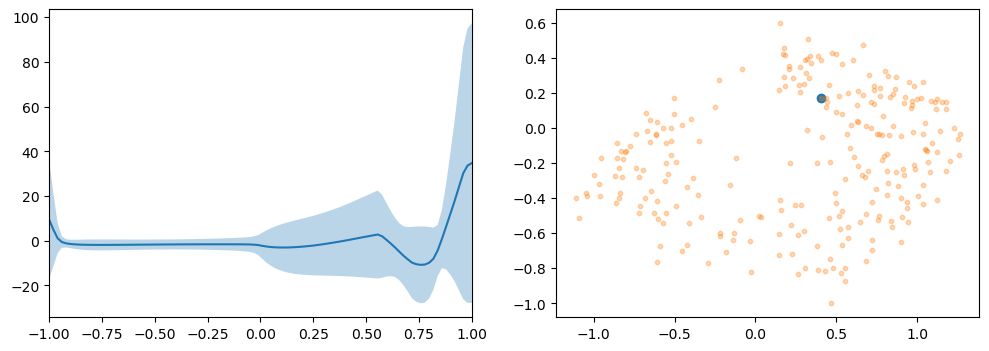

In [17]:
embedding_train = model.meta_blr.meta_model.task_embedding(torch.tensor(10, device=device))
mean, var = model.predict(x_numerical, obj_embedding=torch.tensor([1], device=device), task_embedding=embedding_train)
embedding_train = embedding_train.detach().cpu()

fig = plt.figure(figsize=(12, 4))
ax_meta = plt.subplot2grid((1, 2), (0, 0))
ax_meta.plot(x_config, mean)
ax_meta.fill_between(
    x_config.squeeze(),
    (mean + 2*np.sqrt(var)).squeeze(),
    (mean - 2*np.sqrt(var)).squeeze(),
    alpha=.3
)
ax_meta.set_xlim(*forrester_p.search_space['x']['parameter'].bounds)

ax_embeddding = plt.subplot2grid((1, 2), (0, 1))
ax_embeddding.scatter(embedding_train[0], embedding_train[1])
ax_embeddding.scatter(
    *model.meta_blr.meta_model.task_embedding.weight[1:num_tasks_per_obj+1, :].T.detach().cpu(),
    label='task embedding', s=10, alpha=.3);

## Train embedding visualization objective 2

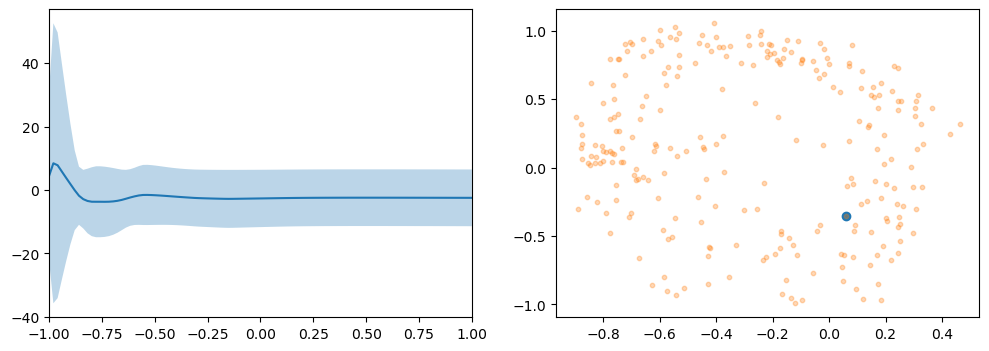

In [22]:
embedding_train = model.meta_blr.meta_model.task_embedding(torch.tensor(num_tasks_per_obj+10, device=device)).detach()
mean, var = model.predict(x_numerical, obj_embedding=torch.tensor([2], device=device), task_embedding=embedding_train)
embedding_train = embedding_train.detach().cpu()

fig = plt.figure(figsize=(12, 4))
ax_meta = plt.subplot2grid((1, 2), (0, 0))
ax_meta.plot(x_config, mean)
ax_meta.fill_between(
    x_config.squeeze(),
    (mean + 2*np.sqrt(var)).squeeze(),
    (mean - 2*np.sqrt(var)).squeeze(),
    alpha=.3
)
ax_meta.set_xlim(*forrester_p.search_space['x']['parameter'].bounds)

ax_embeddding = plt.subplot2grid((1, 2), (0, 1))
ax_embeddding.scatter(embedding_train[0], embedding_train[1]);
ax_embeddding.scatter(
    *model.meta_blr.meta_model.task_embedding.weight[num_tasks_per_obj+1:, :].T.detach().cpu(),
    label='task embedding', s=10, alpha=.3);

### Task vector samples

In [19]:
prior = dist.MultivariateNormal(
    loc=torch.zeros(num_features),
    covariance_matrix=torch.eye(num_features)
)
prior_samples = prior.sample([512])
task_samples = prior.sample([5])

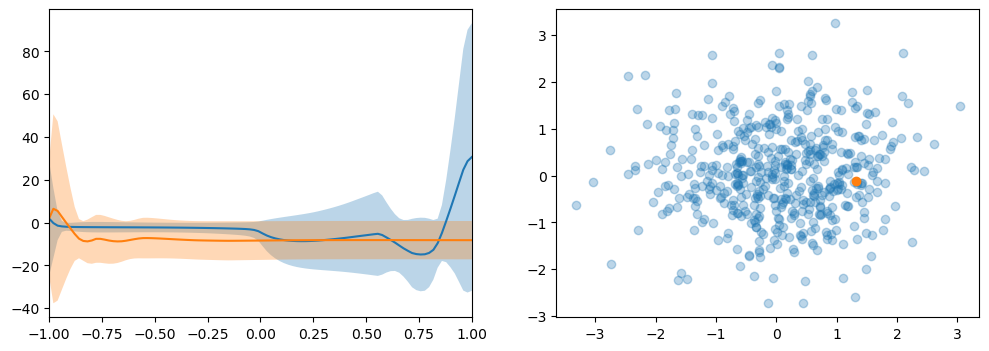

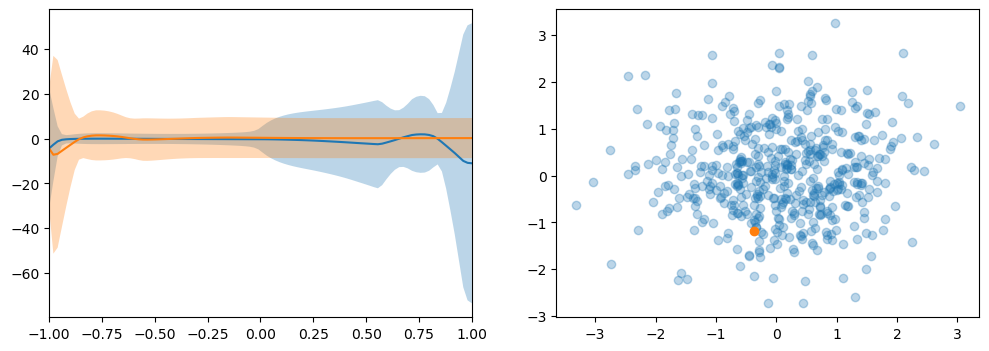

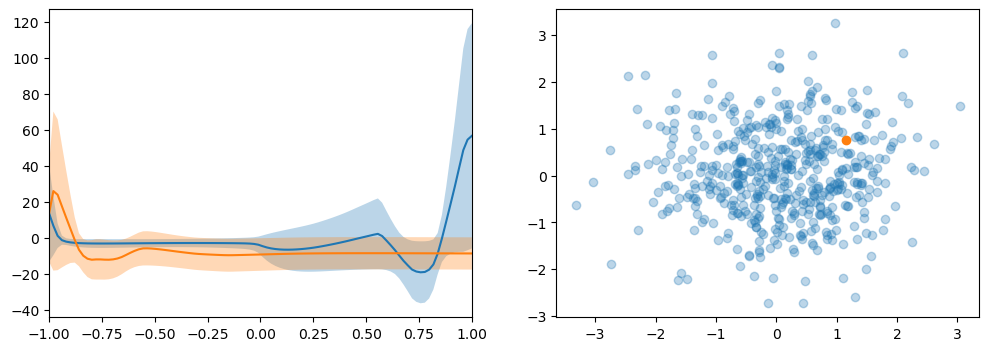

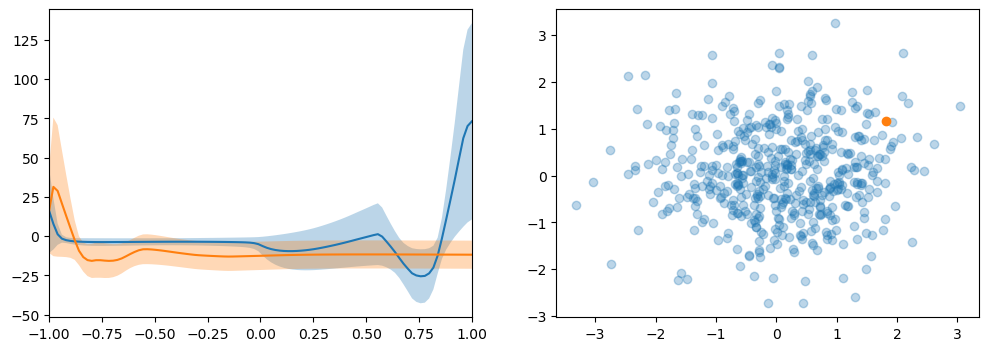

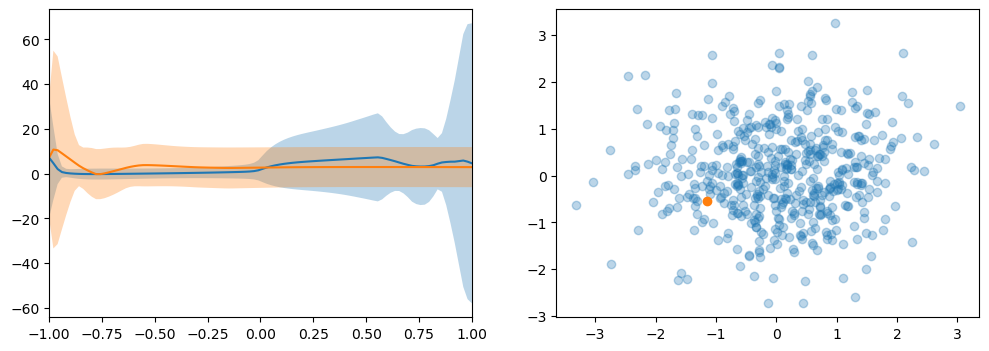

In [20]:
for sample in task_samples:
    fig = plt.figure(figsize=(12, 4))
    ax_meta = plt.subplot2grid((1, 2), (0, 0))

    for obj_embedding in [1, 2]:
        mean, var = model.predict(
            x_numerical,
            obj_embedding=torch.tensor([obj_embedding], device=device),
            task_embedding=sample.to(device)
        )
        ax_meta.plot(x_config, mean)
        ax_meta.fill_between(
            x_config.squeeze(),
            (mean + 2*np.sqrt(var)).squeeze(),
            (mean - 2*np.sqrt(var)).squeeze(),
            alpha=.3
        )

    ax_meta.set_xlim(*forrester_p.search_space['x']['parameter'].bounds)

    ax_embeddding = plt.subplot2grid((1, 2), (0, 1))
    ax_embeddding.scatter(prior_samples[:, 0], prior_samples[:, 1], alpha=.3)
    ax_embeddding.scatter(sample[0], sample[1]);